# Multi-class image classification

In [48]:
## All imports needed
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.metrics import f1_score, accuracy_score


## One class per-image

In this setup you have labelled images that are in one of N classes. The goal is to match unlabelled images to the correct class. We'll use accuracy (number of correctly labelled examples / total examples) as our simple measure of how well the model is performing.

### Plant Seedlings 
From https://www.kaggle.com/c/plant-seedlings-classification

#### Data preparation
First we need to get hold of the data. Using the kaggle API and then extracting the compressed files:

In [ ]:
! kaggle competitions download -c plant-seedlings-classification

os.makedirs('data', exist_ok=True)
! cp -R ~/.kaggle/competitions/plant-seedlings-classification/ data/
! cd data/plant-seedlings-classification/ && unzip train.zip
! cd data/plant-seedlings-classification/ && unzip test.zip

Use the Fast AI data loader to load from directories organised as `../train/class1`, `../train/class2` etc.

In [2]:
PATH = 'data/plant-seedlings-classification'

print('\nTraining data folder contains a folder per class:\n')
!ls $PATH/train
print('\nEach class folder contains images:\n')
!ls $PATH/train/Black-grass | head 


Training data folder contains a folder per class:

Black-grass  Cleavers	       Common wheat  Loose Silky-bent	Shepherds Purse
Charlock     Common Chickweed  Fat Hen	     Scentless Mayweed	Sugar beet

Each class folder contains images:

0050f38b3.png
05eedce4d.png
075d004bc.png
078eae073.png
082314602.png
0ace21089.png
0b228a6b8.png
0b3e7a7a9.png
0bb75ded8.png
0be707615.png


The data doesn't include a validation set, so we'll make one by taking 20% of the training set and putting it into a folder `valid/`

In [35]:
categories = os.listdir(f'{PATH}/train')

os.makedirs(f'{PATH}/valid', exist_ok=True)

for category in categories:
    os.makedirs(f'{PATH}/valid/{category}', exist_ok=True)
    
    files = os.listdir(f'{PATH}/train/{category}')
    
    valid_files = random.sample(files, math.floor(len(files) * 0.2))

    for f in valid_files:
        os.rename(f'{PATH}/train/{category}/{f}', f'{PATH}/valid/{category}/{f}')

Have a look at the data to get a sense of what it looks like

#### Data exploration

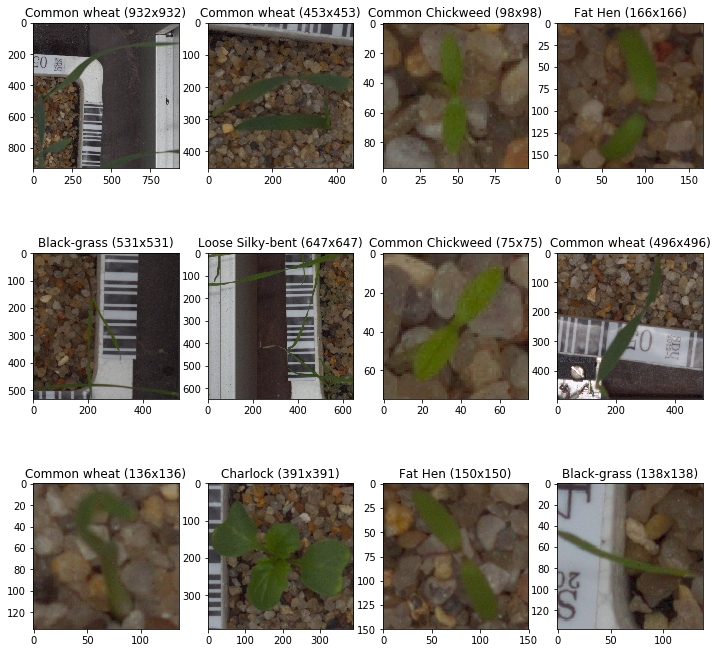

In [75]:
arch=resnet34
sz = 224

data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test')

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

def get_img_with_class(ds, y, classes, idx):    
    img = load_img_id(ds, idx)
    class_name = classes[y[idx]]
    size = f'{img.shape[0]}x{img.shape[0]}'
    title = f'{class_name} ({size})'
    
    return img, title

def plot_images(ds, y, classes, idxs):
    f = plt.figure(figsize=(12,12))
    for i, idx in enumerate(idxs):
        sp = f.add_subplot(3, 4, i+1)

        img, title = get_img_with_class(ds, y, classes, idx)
        sp.set_title(title)
        plt.imshow(img)    

idxs = np.random.randint(len(data.trn_ds), size=12)
plot_images(data.trn_ds, data.trn_y, data.classes, idxs)


It seems like basically all of the photos are taken from directly above. This means we can apply transformations vertically and horizontally without changing the meaning of the image. All the photos are also quite tightly cropped to the plant, so we will want to restrict random zooming to a small amount.

These are a couple of helper functions to make it easier to test out multiple variations of hyper parameters and sizes

In [38]:
#### Modelling

In [77]:
def get_data(arch, sz=299, bs=32):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, test_name='test')

def learn_size(learn, sz, lr, lrs):
    learn.set_data(get_data(resnet50, sz=sz))
    learn.freeze()
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
    learn.unfreeze()
    learn.fit(np.array([i*lr for i in lrs]), 3, cycle_len=1, cycle_mult=2)
    return learn

# precompute must be false, otherwise unfreezing the earlier resnet layers will have no effect
learn = ConvLearner.pretrained(resnet50, get_data(resnet50, sz=64), precompute=False)

Use the _learning-rate finder_ built into FastAI to plot loss as learning rate increases. The best practice is to take the point where loss is decreasing most rapidly - not when it has already started to plateau.

 86%|████████▌ | 87/101 [00:06<00:00, 14.17it/s, loss=12.5]


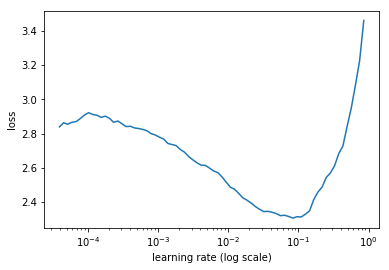

In [5]:
learn.lr_find()
learn.sched.plot()

It looks like something around 2e-2 should do the trick

In [6]:
learn = learn_size(learn, 64, 2e-2, [1/500, 1/50, 1/5])

[ 0.       1.66831  1.20377  0.59976]                       
[ 1.       1.53451  1.16114  0.59135]                      
[ 2.       1.34547  1.04929  0.62861]                      
[ 3.       1.43248  1.12391  0.64423]                      
[ 4.       1.31167  1.02662  0.66827]                      
[ 5.       1.21362  0.98269  0.68269]                       
[ 6.       1.15504  0.97066  0.66827]                       



[ 0.       1.40971  1.27125  0.5613 ]                       
[ 1.       1.04427  0.86854  0.70192]                       
[ 2.       0.86074  0.84687  0.71274]                        
[ 3.       0.78113  0.66049  0.76923]                        
[ 4.       0.67981  0.63023  0.77644]                       
[ 5.       0.60873  0.5923   0.79928]                        
[ 6.       0.53758  0.57295  0.8125 ]                        



Increase the image size and train further. Run the learning rate finder again to check if we need to adjust the learning rate with a different image size.

 88%|████████▊ | 89/101 [00:06<00:00, 13.09it/s, loss=5]    


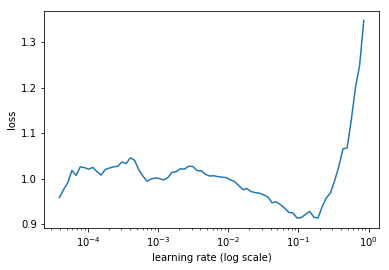

In [8]:
learn.set_data(get_data(resnet50, sz=128))
learn.lr_find()
learn.sched.plot()

Looks like we're closer to something like 8e-2 this time

In [11]:
learn = learn_size(learn, 128, 8e-2, [1/500, 1/50, 1/5])
learn.save('resnet50.64.128') # save the state of the model in case something goes wrong later

Now repeat the process for 256x256

 93%|█████████▎| 94/101 [00:24<00:01,  3.77it/s, loss=3.23] 

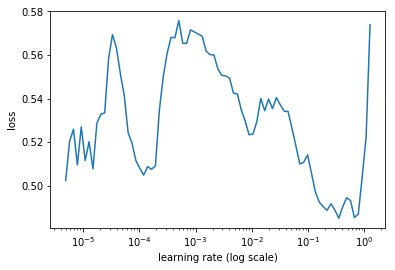

In [13]:
learn.set_data(get_data(resnet50, sz=256))
learn.lr_find(start_lr=1e-6)
learn.sched.plot()

In [ ]:
learn = learn_size(learn, 256, 1e-1, [1/500, 1/50, 1/5])
learn.save('resnet50.64.128.256')

96% accuracy on validation - not too bad! Let's try and eek out a little more accuracy by going up to 299x299.

In [18]:
learn.load('resnet50.64.128.256')
learn = learn_size(learn, 299, 1e-1, [1/500, 1/50, 1/5])
learn.save('resnet50.64.128.256.299')

[ 0.       0.05352  0.13115  0.95673]                         
[ 1.       0.071    0.13987  0.96394]                         
[ 2.       0.05229  0.13834  0.96154]                         
[ 3.       0.05759  0.14946  0.95553]                         
[ 4.       0.0507   0.14309  0.96034]                         
[ 5.       0.04911  0.12793  0.96274]                         
[ 6.       0.04014  0.13045  0.96154]                         



[ 0.       0.09595  0.16737  0.95673]                         
[ 1.       0.10512  0.16933  0.94111]                        
[ 2.       0.06428  0.13123  0.96274]                         
[ 3.       0.09112  0.23529  0.94471]                         
[ 4.       0.06758  0.15296  0.95312]                         
[ 5.       0.05824  0.14922  0.95553]                         
[ 6.       0.03732  0.14683  0.95673]                         



That TTA() method call does "test time augmentation" - basically doing the same augmentation that we did for the training set and then averaging the predictions.

In [86]:
learn.load('resnet50.64.128.256.299')
log_preds,y = learn.TTA()
preds = np.argmax(np.exp(log_preds), axis=1)
f1_score(y, preds, average='micro')

0.97388059701492535

We had to resize the data 3 times to get that result. Was it worth it? Let's try just going straight to the 299 size.

 88%|████████▊ | 89/101 [00:23<00:03,  3.75it/s, loss=9.62]

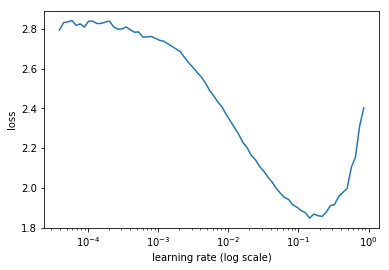

In [36]:
learn = ConvLearner.pretrained(resnet50, get_data(resnet50, sz=299), precompute=False)
learn.lr_find()
learn.sched.plot()

In [39]:
learn = learn_size(learn, 299, 5e-2, [1/500, 1/50, 1/5])
learn.save('resnet50.299')

95.5% accuracy is looking promising, let's lower the learning rate and try a bit more.

In [87]:
learn.load('resnet50.299')
learn = learn_size(learn, 299, 3e-2, [1/500, 1/50, 1/5])
learn.save('resnet50.299x2')

learn.load('resnet50.299x2')
log_preds,y = learn.TTA()
preds = np.argmax(np.exp(log_preds), axis=1)
print("Test set accuracy: ", accuracy_score(y, preds))

Test set accuracy:  0.970149253731           


So in the end we couldn't quite beat the earlier score of 97.39% accuracy.

#### Ensemble

Since we went to the trouble of generating two models, we might as well see if an ensemble could work even better. Although they are likely to be correlated because of the similar architecture, there may have been enough difference in training to get an advantage. Let's try simply averaging the probability scores of the two models.

In [88]:
learn.load('resnet50.64.128.256.299')
log_preds,_ = learn.TTA()
probs_1 = np.exp(log_preds)

learn.load('resnet50.299x2')
log_preds,y = learn.TTA()
probs_2 = np.exp(log_preds)

probs_avg = (probs_1 + probs_2) / 2
preds = np.argmax(probs_avg, axis = 1)
accuracy_score(y, preds)

0.97636815920398012

So we manged to get to 97.64% using a 97.0% and a 97.39%. Every little helps - this would just get us into the top 25% of the Kaggle competition. Perhaps if we trained another architecture and ensembled that as well we could boost it further.

### Results inspection

NOT  Loose Silky-bent
NOT  Loose Silky-bent
NOT  Common Chickweed


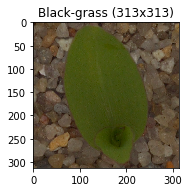

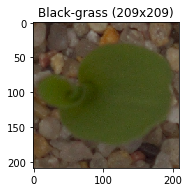

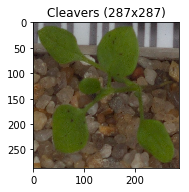

In [103]:
# Get all the incorrectly classified indexes:
incorrect_idxs = [i for i, x in enumerate([x==y for x,y in zip(y, preds)]) if not x]

for _ in range(1,4):
    idx_idx = random.randint(0,len(incorrect_idxs)-1)
    print("NOT ",data.classes[preds[incorrect_idxs[idx_idx]]])
    plot_images(data.test_ds, y, data.classes, incorrect_idxs[idx_idx:idx_idx+1])